In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pbdlib as pbd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from pbdlib.utils.jupyter_utils import *
np.set_printoptions(precision=2)

Import data

In [4]:
dp = os.path.dirname(pbd.__file__) + '/data/demos/corrected'
filelist = next(os.walk(dp))[2]
filelist_short = filelist[0:25]
data = []
for f in filelist_short:
    temp = np.genfromtxt(dp + '/' + f, delimiter=',')
    data.append(temp)

In [3]:
print filelist_short

['trial_024_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_113_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_085_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_142_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_016_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_145_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_110_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_019_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_138_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_103_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_136_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_112_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_123_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_097_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_116_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_081_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_029_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_018_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_115_slash_relaxed_ik

In [5]:
t = np.linspace(0, 100, data[0].shape[0])

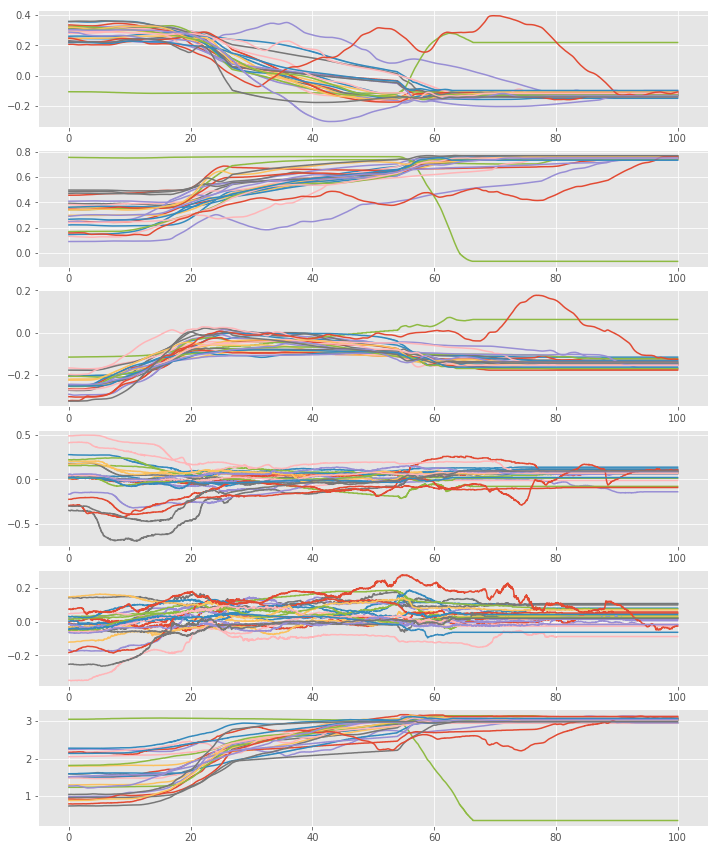

In [5]:
# plotting
fig, ax = plt.subplots(nrows=6)
fig.set_size_inches(12,15)
for i in range(6):
    for p in data:
        ax[i].plot(t, p[:, i])

In [9]:
# Fix for start and end frame
data_start = []
data_end = []
def transform_matrix_3D(a, init):
    # Translation
    dX = - init[0]
    dY = - init[1]
    dZ = - init[2]

    # Rotation
    rC = np.cos(init[3])
    rS = np.sin(init[3])
    pC = np.cos(init[4])
    pS = np.sin(init[4])
    yC = np.cos(init[5])
    yS = np.sin(init[5])

    #Matrices and dot product
    Translate_matrix = np.array([[1, 0, 0, dX],
                               [0, 1, 0, dY],
                               [0, 0, 1, dZ],
                               [0, 0, 0, 1]])
    Rotate_X_matrix = np.array([[1, 0, 0, 0],
                              [0, rC, -rS, 0],
                              [0, rS, rC, 0],
                              [0, 0, 0, 1]])
    Rotate_Y_matrix = np.array([[pC, 0, pS, 0],
                              [0, 1, 0, 0],
                              [-pS, 0, pC, 0],
                              [0, 0, 0, 1]])
    Rotate_Z_matrix = np.array([[yC, -yS, 0, 0],
                              [yS, yC, 0, 0],
                              [0, 0, 1, 0],
                              [0, 0, 0, 1]])
    rot_3d_matrix = np.dot(Rotate_Z_matrix,np.dot(Rotate_Y_matrix,np.dot(Rotate_X_matrix,Translate_matrix)))

    # Apply translation and rotation
    pos = [a[0], a[1], a[2], 1]
    pos_trans = np.dot(rot_3d_matrix,np.transpose(pos))[0:3]
    ori_trans = a[3:] - init[3:]
    pose_trans = np.concatenate((pos_trans, ori_trans), axis=None)

    return pose_trans

for p in data:
    # Set start point
    start = p[0,:]
    arr_trans = np.apply_along_axis(transform_matrix_3D, 1, p, start)
    data_start.append(arr_trans)

for p in data:
    # Set end point
    end = p[-1,:]
    arr_trans = np.apply_along_axis(transform_matrix_3D, 1, p, end)
    data_end.append(arr_trans)

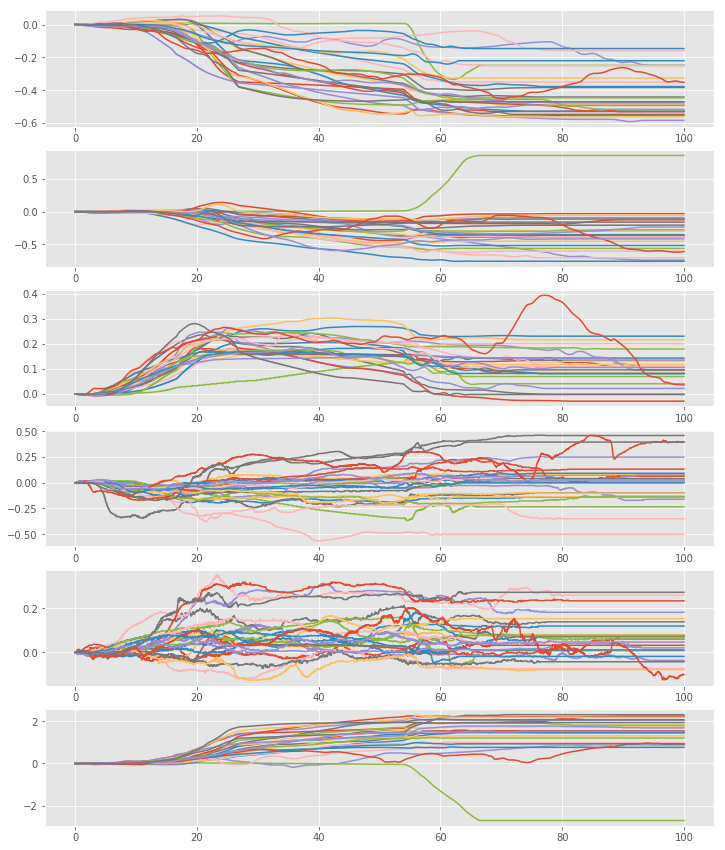

In [10]:
# plotting
fig, ax = plt.subplots(nrows=6)
fig.set_size_inches(12,15)
for i in range(6):
    for p in data_start:
        ax[i].plot(t, p[:, i])

In [48]:
hmm_demos = [np.hstack([s, e]) for e in data_end for s in data_start]

hmm = pbd.HMM(nb_dim=12, nb_states=5)

hmm.init_hmm_kbins(hmm_demos)

hmm.em(hmm_demos, reg=1e-6)

EM did not converge


False

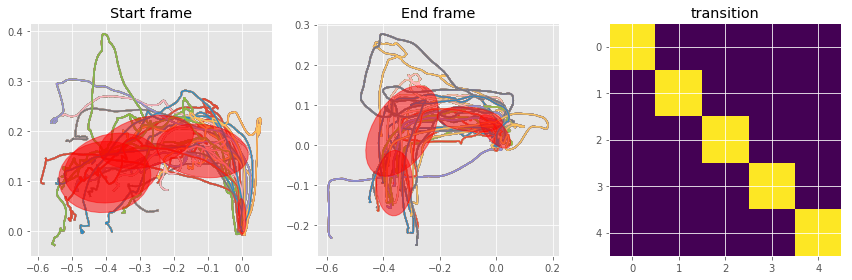

In [52]:
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(12,4)

ax[0].set_title('Start frame')
pbd.plot_gmm(hmm.mu, hmm.sigma, ax=ax[0], dim=[0, 2])
for p in hmm_demos:
    ax[0].plot(p[:, 0], p[:, 2])
    
ax[1].set_title('End frame')
pbd.plot_gmm(hmm.mu, hmm.sigma, ax=ax[1], dim=[6, 8])
for p in hmm_demos:
    ax[1].plot(p[:, 6], p[:, 8])
    
# plotting transition matrix
ax[2].set_title('transition')
ax[2].imshow(np.log(hmm.Trans+1e-10), interpolation='nearest', vmin=-5, cmap='viridis');
plt.tight_layout()

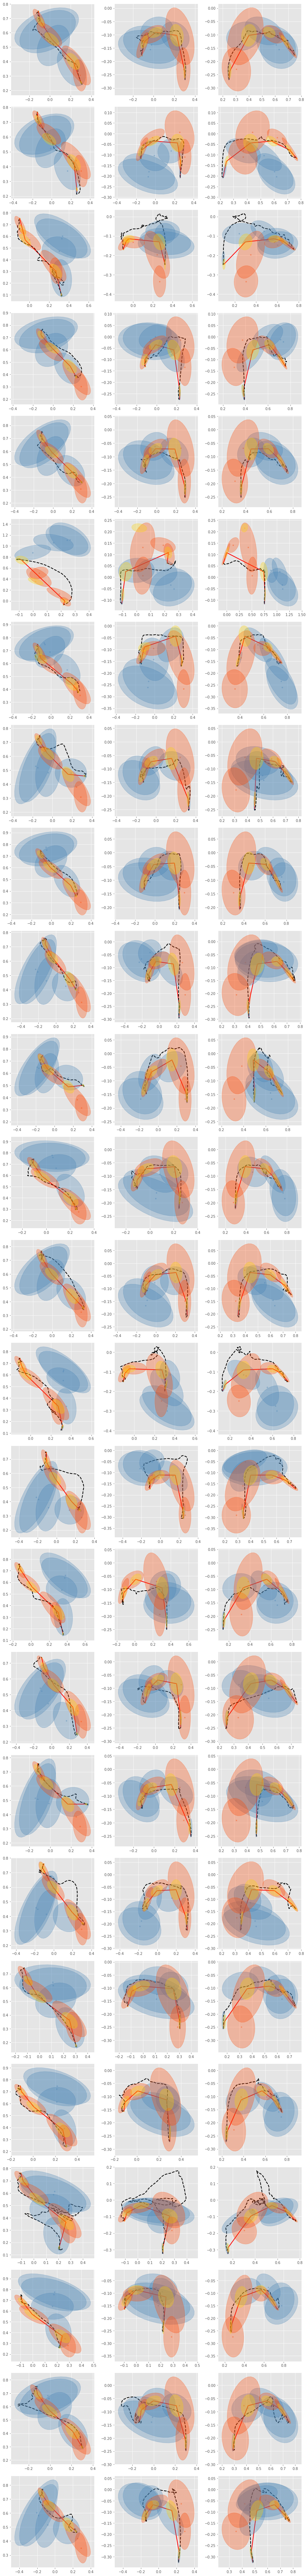

In [49]:
nbcol = 3
fig, ax = plt.subplots(ncols=3, nrows=len(data))
fig.set_size_inches(12, 4 * len(data))
ax = ax.reshape(-1)
A, b = pbd.utils.get_canonical(6, 1, 0.025)

def inv_for_lintrans(pose):
    # Rotation
    rC = np.cos(pose[3])
    rS = np.sin(pose[3])
    pC = np.cos(pose[4])
    pS = np.sin(pose[4])
    yC = np.cos(pose[5])
    yS = np.sin(pose[5])

    Rotate_X_matrix = np.array([[1, 0, 0, 0],
                              [0, rC, -rS, 0],
                              [0, rS, rC, 0],
                              [0, 0, 0, 1]])
    Rotate_Y_matrix = np.array([[pC, 0, pS, 0],
                              [0, 1, 0, 0],
                              [-pS, 0, pC, 0],
                              [0, 0, 0, 1]])
    Rotate_Z_matrix = np.array([[yC, -yS, 0, 0],
                              [yS, yC, 0, 0],
                              [0, 0, 1, 0],
                              [0, 0, 0, 1]])
    rot_3d_matrix = np.dot(Rotate_Z_matrix,np.dot(Rotate_Y_matrix,Rotate_X_matrix))
    inv_rot_3d_matrix = np.linalg.inv(rot_3d_matrix)

    A = np.identity(n=6)
    A[0:3,0:3] = inv_rot_3d_matrix[0:3,0:3]
    # Translation
    b = pose
    return A, b

for i in range(len(data)):
    A0, b0 = inv_for_lintrans(data[i][0,:])
    An, bn = inv_for_lintrans(data[i][-1,:])
    
    _mod1 = hmm.marginal_model(slice(0, 6)).lintrans(A0, b0)
    _mod2 = hmm.marginal_model(slice(6, 12)).lintrans(An, bn)
    
    # product 
    _prod = _mod1 * (_mod2*_mod2)
    
    # get the most probable sequence of state for this demonstration
    sq = hmm.viterbi(hmm_demos[i])
    
    # solving LQR
    lqr = pbd.LQR(A, b, dt=0.025, horizon=data[0].shape[0])
    lqr.gmm_xi = _prod, sq
    lqr.gmm_u = -4.
    lqr.ricatti()
    
    pos = data[i][0]
    xi, _ = lqr.get_seq(pos)
    
    # Plot XY
    ax[3*i].plot(xi[:, 0], xi[:, 1], color='r', lw=2)
            
    pbd.plot_gmm(_mod1.mu, _mod1.sigma, swap=True, ax=ax[3*i], dim=[0, 1], color='steelblue', alpha=0.3)
    pbd.plot_gmm(_mod2.mu, _mod2.sigma, swap=True, ax=ax[3*i], dim=[0, 1], color='orangered', alpha=0.3)
    
    pbd.plot_gmm(_prod.mu, _prod.sigma, swap=True, ax=ax[3*i], dim=[0, 1], color='gold', alpha=0.3)
        
    ax[3*i].plot(data[i][:, 0], data[i][:, 1], 'k--', lw=2)
    
    # Plot XZ
    ax[3*i+1].plot(xi[:, 0], xi[:, 2], color='r', lw=2)
            
    pbd.plot_gmm(_mod1.mu, _mod1.sigma, swap=True, ax=ax[3*i+1], dim=[0, 2], color='steelblue', alpha=0.3)
    pbd.plot_gmm(_mod2.mu, _mod2.sigma, swap=True, ax=ax[3*i+1], dim=[0, 2], color='orangered', alpha=0.3)
    
    pbd.plot_gmm(_prod.mu, _prod.sigma, swap=True, ax=ax[3*i+1], dim=[0, 2], color='gold', alpha=0.3)
        
    ax[3*i+1].plot(data[i][:, 0], data[i][:, 2], 'k--', lw=2)
    
    # Plot YZ
    ax[3*i+2].plot(xi[:, 1], xi[:, 2], color='r', lw=2)
            
    pbd.plot_gmm(_mod1.mu, _mod1.sigma, swap=True, ax=ax[3*i+2], dim=[1, 2], color='steelblue', alpha=0.3)
    pbd.plot_gmm(_mod2.mu, _mod2.sigma, swap=True, ax=ax[3*i+2], dim=[1, 2], color='orangered', alpha=0.3)
    
    pbd.plot_gmm(_prod.mu, _prod.sigma, swap=True, ax=ax[3*i+2], dim=[1, 2], color='gold', alpha=0.3)
        
    ax[3*i+2].plot(data[i][:, 1], data[i][:, 2], 'k--', lw=2)

plt.tight_layout()

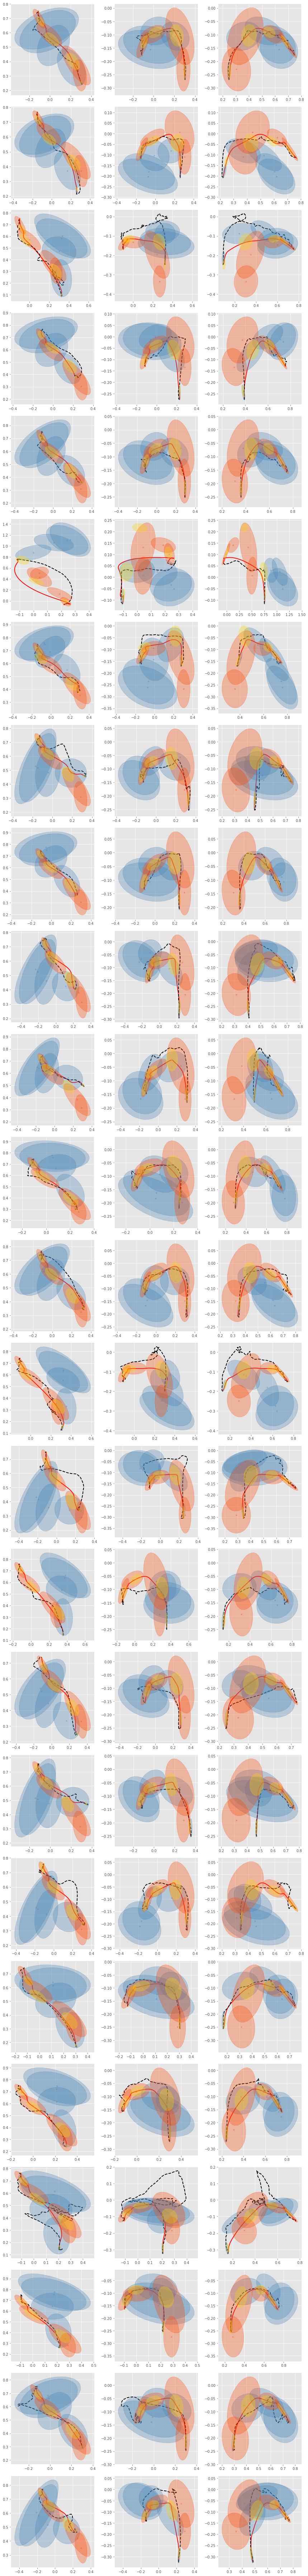

In [50]:
nbcol = 3
fig, ax = plt.subplots(ncols=3, nrows=len(data))
fig.set_size_inches(12, 4 * len(data))
ax = ax.reshape(-1)
A, b = pbd.utils.get_canonical(6, 1, 0.025)

def inv_for_lintrans(pose):
    # Rotation
    rC = np.cos(pose[3])
    rS = np.sin(pose[3])
    pC = np.cos(pose[4])
    pS = np.sin(pose[4])
    yC = np.cos(pose[5])
    yS = np.sin(pose[5])

    Rotate_X_matrix = np.array([[1, 0, 0, 0],
                              [0, rC, -rS, 0],
                              [0, rS, rC, 0],
                              [0, 0, 0, 1]])
    Rotate_Y_matrix = np.array([[pC, 0, pS, 0],
                              [0, 1, 0, 0],
                              [-pS, 0, pC, 0],
                              [0, 0, 0, 1]])
    Rotate_Z_matrix = np.array([[yC, -yS, 0, 0],
                              [yS, yC, 0, 0],
                              [0, 0, 1, 0],
                              [0, 0, 0, 1]])
    rot_3d_matrix = np.dot(Rotate_Z_matrix,np.dot(Rotate_Y_matrix,Rotate_X_matrix))
    inv_rot_3d_matrix = np.linalg.inv(rot_3d_matrix)

    A = np.identity(n=6)
    A[0:3,0:3] = inv_rot_3d_matrix[0:3,0:3]
    # Translation
    b = pose
    return A, b

for i in range(len(data)):
    A0, b0 = inv_for_lintrans(data[i][0,:])
    An, bn = inv_for_lintrans(data[i][-1,:])
    
    _mod1 = hmm.marginal_model(slice(0, 6)).lintrans(A0, b0)
    _mod2 = hmm.marginal_model(slice(6, 12)).lintrans(An, bn)
    
    # product 
    _prod = _mod1 * (_mod2*_mod2)
    
    # get the most probable sequence of state for this demonstration
    sq = hmm.viterbi(hmm_demos[i])
    
    # solving LQR
    lqr = pbd.LQR(A, b, dt=0.025, horizon=data[0].shape[0])
    lqr.gmm_xi = _prod, sq
    lqr.gmm_u = 4.0
    lqr.ricatti()
    
    xi, _ = lqr.get_seq(data[i][0])
    
    # Plot XY
    ax[3*i].plot(xi[:, 0], xi[:, 1], color='r', lw=2)
            
    pbd.plot_gmm(_mod1.mu, _mod1.sigma, swap=True, ax=ax[3*i], dim=[0, 1], color='steelblue', alpha=0.3)
    pbd.plot_gmm(_mod2.mu, _mod2.sigma, swap=True, ax=ax[3*i], dim=[0, 1], color='orangered', alpha=0.3)
    
    pbd.plot_gmm(_prod.mu, _prod.sigma, swap=True, ax=ax[3*i], dim=[0, 1], color='gold', alpha=0.3)
        
    ax[3*i].plot(data[i][:, 0], data[i][:, 1], 'k--', lw=2)
    
    # Plot XZ
    ax[3*i+1].plot(xi[:, 0], xi[:, 2], color='r', lw=2)
            
    pbd.plot_gmm(_mod1.mu, _mod1.sigma, swap=True, ax=ax[3*i+1], dim=[0, 2], color='steelblue', alpha=0.3)
    pbd.plot_gmm(_mod2.mu, _mod2.sigma, swap=True, ax=ax[3*i+1], dim=[0, 2], color='orangered', alpha=0.3)
    
    pbd.plot_gmm(_prod.mu, _prod.sigma, swap=True, ax=ax[3*i+1], dim=[0, 2], color='gold', alpha=0.3)
        
    ax[3*i+1].plot(data[i][:, 0], data[i][:, 2], 'k--', lw=2)
    
    # Plot YZ
    ax[3*i+2].plot(xi[:, 1], xi[:, 2], color='r', lw=2)
            
    pbd.plot_gmm(_mod1.mu, _mod1.sigma, swap=True, ax=ax[3*i+2], dim=[1, 2], color='steelblue', alpha=0.3)
    pbd.plot_gmm(_mod2.mu, _mod2.sigma, swap=True, ax=ax[3*i+2], dim=[1, 2], color='orangered', alpha=0.3)
    
    pbd.plot_gmm(_prod.mu, _prod.sigma, swap=True, ax=ax[3*i+2], dim=[1, 2], color='gold', alpha=0.3)
        
    ax[3*i+2].plot(data[i][:, 1], data[i][:, 2], 'k--', lw=2)

plt.tight_layout()

In [46]:
gmm_demos = [np.hstack([t[:,None], s, t[:,None], e]) for e in data_end for s in data_start]
gmm_demos2 = np.vstack([d for d in gmm_demos])

gmm = pbd.GMM(nb_dim=14, nb_states=5)

gmm.init_hmm_kbins(gmm_demos)

gmm.em(gmm_demos2, reg=1e-6)

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

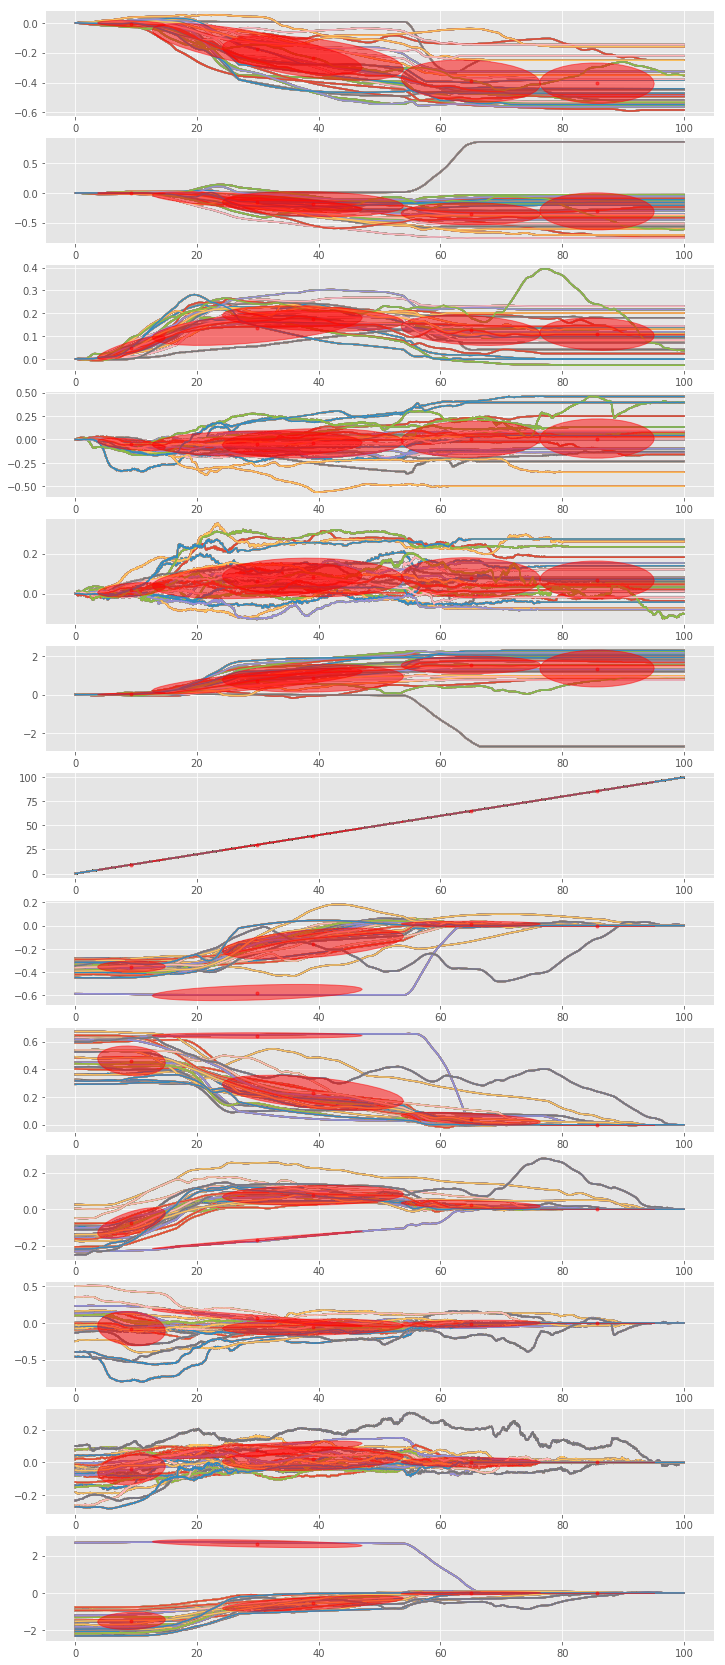

In [51]:
# plotting
fig, ax = plt.subplots(nrows=13)
fig.set_size_inches(12,30)

# position plotting

for i in range(13):

    for p in gmm_demos:
        ax[i].plot(p[:, 0], p[:, i + 1])

    pbd.plot_gmm(gmm.mu, gmm.sigma, ax=ax[i], dim=[0, i + 1]);

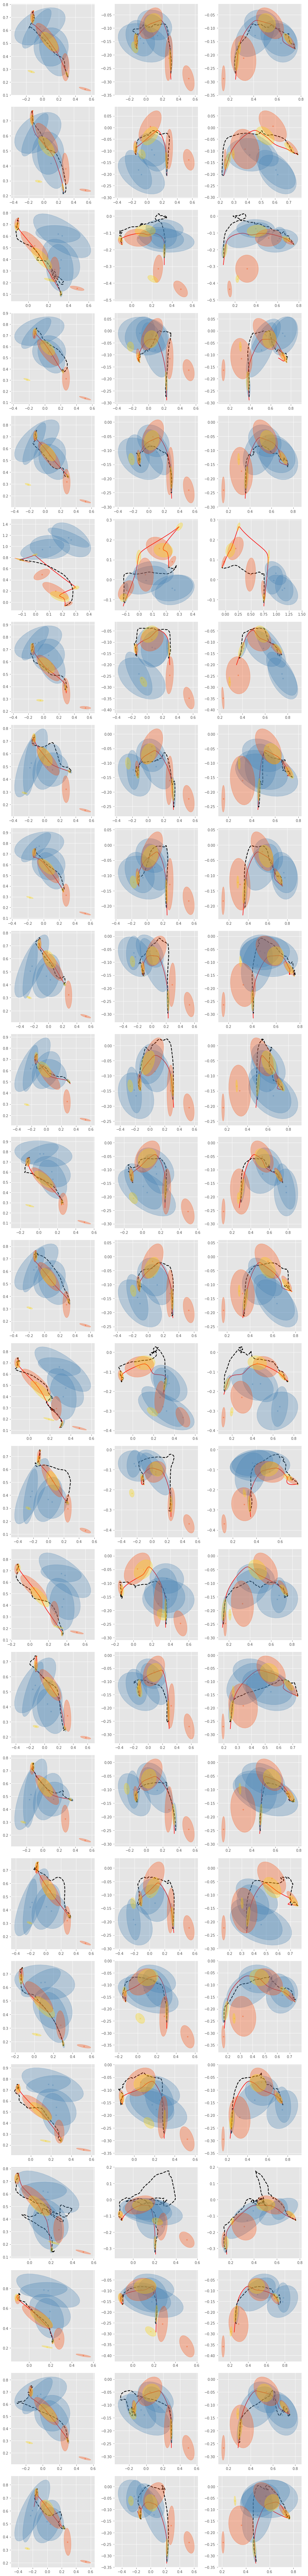

In [47]:
nbcol = 3
fig, ax = plt.subplots(ncols=3, nrows=len(data))
fig.set_size_inches(12, 4 * len(data))
ax = ax.reshape(-1)

for i in range(len(data)):
    A0 = np.identity(n=7)
    An = np.identity(n=7)
    b0 = np.zeros(7)
    bn = np.zeros(7)
    A0[1:7,1:7], b0[1:7] = inv_for_lintrans(data[i][0,:])
    An[1:7,1:7], bn[1:7] = inv_for_lintrans(data[i][-1,:])
        
    _mod1 = gmm.marginal_model(slice(0, 7)).lintrans(A0, b0)
    _mod2 = gmm.marginal_model(slice(7, 14)).lintrans(An, bn)
    
    # product 
    _prod = _mod1 * _mod2
    
    # get the most probable trajectory for this demonstration
    _mu, _sigma = _prod.condition(t[:, None], dim_in=slice(0, 1), dim_out=slice(0, 7))
    
    
    # Plot XY
    pbd.plot_gmm(_mod1.mu, _mod1.sigma, swap=True, ax=ax[3*i], dim=[1, 2], color='steelblue', alpha=0.3)
    pbd.plot_gmm(_mod2.mu, _mod2.sigma, swap=True, ax=ax[3*i], dim=[1, 2], color='orangered', alpha=0.3)
    
    pbd.plot_gmm(_prod.mu, _prod.sigma, swap=True, ax=ax[3*i], dim=[1, 2], color='gold', alpha=0.3)
    # Plot the prediction
    ax[3*i].plot(_mu[:,1], _mu[:,2], color='red')
    
    ax[3*i].plot(data[i][:, 0], data[i][:, 1], 'k--', lw=2)
    
    # Plot XZ
    pbd.plot_gmm(_mod1.mu, _mod1.sigma, swap=True, ax=ax[3*i+1], dim=[1, 3], color='steelblue', alpha=0.3)
    pbd.plot_gmm(_mod2.mu, _mod2.sigma, swap=True, ax=ax[3*i+1], dim=[1, 3], color='orangered', alpha=0.3)
    
    pbd.plot_gmm(_prod.mu, _prod.sigma, swap=True, ax=ax[3*i+1], dim=[1, 3], color='gold', alpha=0.3)
    # Plot the prediction
    ax[3*i+1].plot(_mu[:,1], _mu[:,3], color='red')
    
    ax[3*i+1].plot(data[i][:, 0], data[i][:, 2], 'k--', lw=2)
    
    # Plot XZ
    pbd.plot_gmm(_mod1.mu, _mod1.sigma, swap=True, ax=ax[3*i+2], dim=[2, 3], color='steelblue', alpha=0.3)
    pbd.plot_gmm(_mod2.mu, _mod2.sigma, swap=True, ax=ax[3*i+2], dim=[2, 3], color='orangered', alpha=0.3)
    
    pbd.plot_gmm(_prod.mu, _prod.sigma, swap=True, ax=ax[3*i+2], dim=[2, 3], color='gold', alpha=0.3)
    # Plot the prediction
    ax[3*i+2].plot(_mu[:,2], _mu[:,3], color='red')
    
    ax[3*i+2].plot(data[i][:, 1], data[i][:, 2], 'k--', lw=2)

plt.tight_layout()